# Asset Pricing with the Fama–French Three-Factor Model

This project evaluates the explanatory power of the Capital Asset Pricing Model (CAPM)
and the Fama–French Three-Factor Model (FF3) using monthly returns from the
Fama–French 25 Size–Book-to-Market portfolios.

The objective is to assess whether incorporating size (SMB) and value (HML) factors
improves model fit and reduces pricing errors relative to CAPM, consistent with
modern empirical asset pricing theory.


In [1]:
import os, zipfile, io, requests
import pandas as pd
import numpy as np

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

def download_and_extract_zip(url, dest_dir=DATA_DIR):
    r = requests.get(url)
    r.raise_for_status()
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(dest_dir)
    return [os.path.join(dest_dir, f) for f in z.namelist()]

ff5_files = download_and_extract_zip(
    "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
)
p25_files = download_and_extract_zip(
    "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_5x5_CSV.zip"
)

ff5_csv = [f for f in ff5_files if f.lower().endswith(".csv")][0]
p25_csv = [f for f in p25_files if f.lower().endswith(".csv")][0]

ff5_csv, p25_csv


('data\\F-F_Research_Data_5_Factors_2x3.csv', 'data\\25_Portfolios_5x5.csv')

## 1. Data

The analysis uses publicly available monthly data from the Kenneth R. French Data Library.
Specifically, the dataset includes:

- Fama–French market, size (SMB), and value (HML) factors
- The risk-free rate
- 25 value-weighted portfolios formed on size and book-to-market ratios

All returns are expressed in excess of the risk-free rate and aligned on a common
monthly time index.


In [2]:
def load_ff_factors_monthly(path):
    # Find the header line that contains Mkt-RF and RF
    header_i = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            s = line.strip()
            if ("Mkt-RF" in s) and ("RF" in s):
                header_i = i
                break
    if header_i is None:
        raise ValueError("Could not locate factors header line (with 'Mkt-RF' and 'RF').")

    df = pd.read_csv(path, skiprows=header_i, header=0)
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={df.columns[0]: "Date"})

    df["Date"] = pd.to_datetime(df["Date"].astype(str).str.strip(), format="%Y%m", errors="coerce")
    df = df.dropna(subset=["Date"]).set_index("Date")

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Ensure unique dates (just in case)
    df = df[~df.index.duplicated(keep="first")]
    return df


def load_25_portfolios_monthly(path):
    # The portfolios file contains multiple sections. We ONLY want the Monthly block.
    lines = open(path, "r", encoding="utf-8", errors="ignore").read().splitlines()

    start = None
    for i, line in enumerate(lines):
        if "Average Value Weighted Returns -- Monthly" in line:
            start = i + 1  # header is the next line (starts with comma)
            break
    if start is None:
        raise ValueError("Could not find 'Average Value Weighted Returns -- Monthly' section.")

    end = None
    for i in range(start, len(lines)):
        if "Average Value Weighted Returns -- Annual" in lines[i]:
            end = i
            break
    if end is None:
        end = len(lines)

    monthly_block = "\n".join(lines[start:end])
    df = pd.read_csv(io.StringIO(monthly_block))
    df.columns = [c.strip() for c in df.columns]
    df = df.rename(columns={df.columns[0]: "Date"})

    df["Date"] = pd.to_datetime(df["Date"].astype(str).str.strip(), format="%Y%m", errors="coerce")
    df = df.dropna(subset=["Date"]).set_index("Date")

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Missing codes in Ken French files
    df = df.replace([-99.99, -999], np.nan)

    # Critical: make sure index is unique
    df = df[~df.index.duplicated(keep="first")]
    return df


In [3]:
factors = load_ff_factors_monthly(ff5_csv)
portfolios = load_25_portfolios_monthly(p25_csv)

print("Factors columns:", list(factors.columns))
print("Factors range:", factors.index.min().date(), "->", factors.index.max().date(), " rows:", len(factors))
print("Portfolios range:", portfolios.index.min().date(), "->", portfolios.index.max().date(), " rows:", len(portfolios))

print("Duplicate dates in factors:", factors.index.duplicated().sum())
print("Duplicate dates in portfolios:", portfolios.index.duplicated().sum())

factors.head()


Factors columns: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
Factors range: 1963-07-01 -> 2025-11-01  rows: 749
Portfolios range: 1926-07-01 -> 2025-11-01  rows: 1193
Duplicate dates in factors: 0
Duplicate dates in portfolios: 0


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.48,-0.81,0.64,-1.15,0.27
1963-08-01,5.08,-0.80,1.70,0.40,-0.38,0.25
1963-09-01,-1.57,-0.43,0.00,-0.78,0.15,0.27
1963-10-01,2.54,-1.34,-0.04,2.79,-2.25,0.29
1963-11-01,-0.86,-0.85,1.73,-0.43,2.27,0.27


In [4]:
# Convert percent to decimal
factors = factors / 100.0
portfolios = portfolios / 100.0

# Align dates
common_idx = factors.index.intersection(portfolios.index)
factors = factors.loc[common_idx].copy()
portfolios = portfolios.loc[common_idx].copy()

# Compute excess returns (portfolio minus RF)
rf = factors["RF"]
excess_returns = portfolios.subtract(rf, axis=0)

print("Sample:", common_idx.min().date(), "->", common_idx.max().date())
excess_returns.head()


Sample: 1963-07-01 -> 2025-11-01


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,0.008587,-0.006332,0.004523,-0.003113,-0.015147,-0.020776,-0.000771,-0.012849,-0.022449,-0.014580,...,-0.011815,-0.020433,-0.021868,-0.018445,-0.021274,-0.001309,0.002139,0.008660,-0.006985,-0.013745
1963-08-01,0.039896,0.011230,0.012417,0.022568,0.044144,0.053203,0.042720,0.041950,0.042162,0.079951,...,0.053254,0.044969,0.060016,0.074441,0.050956,0.055323,0.040133,0.043841,0.079204,0.061484
1963-09-01,-0.020043,0.003504,-0.012707,-0.017915,-0.006284,-0.043225,-0.017772,-0.011338,-0.017635,-0.031943,...,-0.029344,-0.024163,-0.020582,-0.042341,-0.022702,-0.016452,-0.010781,-0.011197,-0.004612,-0.037733
1963-10-01,0.000878,-0.010229,0.010166,-0.000996,0.020811,0.009026,0.039511,0.020626,0.020158,0.036414,...,-0.005315,0.004090,0.022314,0.045624,0.003238,0.050361,0.014520,-0.006254,0.021276,0.001802
1963-11-01,-0.036019,-0.041136,-0.020593,-0.013235,-0.013777,-0.045296,-0.020184,-0.010545,-0.003254,-0.003850,...,-0.011783,-0.009011,-0.010216,0.010896,0.032707,-0.015369,0.007380,-0.019614,-0.024016,0.010796


## 2. Methodology

For each of the 25 portfolios, excess returns are regressed on factor returns using
ordinary least squares (OLS).

The following models are estimated:

**CAPM:**
\[
R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,M} (R_{M,t} - R_{f,t}) + \varepsilon_{i,t}
\]

**Fama–French Three-Factor Model (FF3):**
\[
R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,M} (R_{M,t} - R_{f,t})
+ \beta_{i,SMB} SMB_t + \beta_{i,HML} HML_t + \varepsilon_{i,t}
\]

Model performance is evaluated using R², changes in explanatory power (ΔR²),
and the statistical significance of intercepts (alphas).


In [5]:
# Pick one portfolio (example: Small–Low B/M)
y = excess_returns["SMALL LoBM"]

X_capm = factors[["Mkt-RF"]]
X_ff3  = factors[["Mkt-RF", "SMB", "HML"]]


In [6]:
import statsmodels.api as sm

X = sm.add_constant(X_capm)
capm_model = sm.OLS(y, X, missing="drop").fit()

print(capm_model.summary())


                            OLS Regression Results                            
Dep. Variable:             SMALL LoBM   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     1256.
Date:                Tue, 30 Dec 2025   Prob (F-statistic):          3.80e-162
Time:                        10:42:00   Log-Likelihood:                 1201.4
No. Observations:                 749   AIC:                            -2399.
Df Residuals:                     747   BIC:                            -2390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.002     -2.990      0.0

In [7]:
X = sm.add_constant(X_ff3)
ff3_model = sm.OLS(y, X, missing="drop").fit()

print(ff3_model.summary())


                            OLS Regression Results                            
Dep. Variable:             SMALL LoBM   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     2329.
Date:                Tue, 30 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:42:00   Log-Likelihood:                 1708.4
No. Observations:                 749   AIC:                            -3409.
Df Residuals:                     745   BIC:                            -3390.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.001     -4.948      0.0

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_ols(y: pd.Series, X: pd.DataFrame):
    """
    Runs OLS with an intercept. Returns fitted model.
    """
    df = pd.concat([y, X], axis=1).dropna()
    y_clean = df.iloc[:, 0]
    X_clean = sm.add_constant(df.iloc[:, 1:])
    model = sm.OLS(y_clean, X_clean).fit()
    return model

def summarize_model(model, model_name: str):
    """
    Extracts key regression outputs into a dict.
    """
    params = model.params
    tvals  = model.tvalues
    pvals  = model.pvalues
    
    out = {
        "model": model_name,
        "alpha": params.get("const", np.nan),
        "alpha_t": tvals.get("const", np.nan),
        "alpha_p": pvals.get("const", np.nan),
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
        "n": int(model.nobs)
    }
    
    # Add factor loadings if present
    for k in ["Mkt-RF", "SMB", "HML"]:
        out[f"beta_{k}"] = params.get(k, np.nan)
        out[f"t_{k}"] = tvals.get(k, np.nan)
        out[f"p_{k}"] = pvals.get(k, np.nan)
        
    return out


In [9]:
# Define factor matrices
X_capm = factors[["Mkt-RF"]]
X_ff3  = factors[["Mkt-RF", "SMB", "HML"]]

results = []

for port in excess_returns.columns:
    y = excess_returns[port]
    
    capm_model = run_ols(y, X_capm)
    ff3_model  = run_ols(y, X_ff3)
    
    results.append({**{"portfolio": port}, **summarize_model(capm_model, "CAPM")})
    results.append({**{"portfolio": port}, **summarize_model(ff3_model,  "FF3")})

res = pd.DataFrame(results)

# Make it easier to compare models side-by-side later
res.head(6)


,portfolio,model,alpha,alpha_t,alpha_p,r2,adj_r2,n,beta_Mkt-RF,t_Mkt-RF,p_Mkt-RF,beta_SMB,t_SMB,p_SMB,beta_HML,t_HML,p_HML
0,SMALL LoBM,CAPM,-0.005370,-2.990138,2.880114e-03,0.627044,0.626545,749,1.414900,35.438956,3.802451e-162,NaN,NaN,NaN,NaN,NaN,NaN
1,SMALL LoBM,FF3,-0.004558,-4.947563,9.295822e-07,0.903662,0.903274,749,1.087734,50.218879,2.413155e-241,1.392298,44.592778,1.713996e-212,-0.483733,-15.476808,4.688421e-47
2,ME1 BM2,CAPM,0.000457,0.288910,7.727306e-01,0.617835,0.617324,749,1.223127,34.751328,3.466660e-158,NaN,NaN,NaN,NaN,NaN,NaN
3,ME1 BM2,FF3,0.000281,0.389033,6.973629e-01,0.921804,0.921489,749,0.949797,55.888704,1.068181e-268,1.314265,53.649282,4.264280e-258,-0.198606,-8.098699,2.266181e-15
4,ME1 BM3,CAPM,0.001089,0.840180,4.010761e-01,0.667051,0.666605,749,1.114756,38.685706,1.448978e-180,NaN,NaN,NaN,NaN,NaN,NaN
5,ME1 BM3,FF3,-0.000077,-0.145910,8.840320e-01,0.946417,0.946201,749,0.926106,75.052938,0.000000e+00,1.091545,61.367187,1.475141e-293,0.113850,6.393986,2.850954e-10


## 3. Empirical Results

This section compares CAPM and FF3 across all 25 portfolios.
Key evaluation metrics include:

- Model explanatory power (R²)
- Improvement in fit when moving from CAPM to FF3 (ΔR²)
- Magnitude and statistical significance of pricing errors (alphas)

Results are summarized both at the individual portfolio level and in aggregate.


In [10]:
capm = res[res["model"] == "CAPM"].set_index("portfolio")
ff3  = res[res["model"] == "FF3"].set_index("portfolio")

compare = pd.DataFrame({
    "R2_CAPM": capm["r2"],
    "R2_FF3": ff3["r2"],
    "Delta_R2": ff3["r2"] - capm["r2"],
    
    "Alpha_CAPM": capm["alpha"],
    "Alpha_FF3": ff3["alpha"],
    "AbsAlpha_CAPM": capm["alpha"].abs(),
    "AbsAlpha_FF3": ff3["alpha"].abs(),
    
    "Alpha_p_CAPM": capm["alpha_p"],
    "Alpha_p_FF3": ff3["alpha_p"],
})

compare = compare.sort_values("Delta_R2", ascending=False)
compare.head(10)


,R2_CAPM,R2_FF3,Delta_R2,Alpha_CAPM,Alpha_FF3,AbsAlpha_CAPM,AbsAlpha_FF3,Alpha_p_CAPM,Alpha_p_FF3
portfolio,,,,,,,,,
SMALL HiBM,0.575829,0.902868,0.327039,0.004605,0.001958,0.004605,0.001958,0.002355,7.384388e-03
ME1 BM4,0.629353,0.951396,0.322043,0.003235,0.001382,0.003235,0.001382,0.014061,4.120196e-03
ME1 BM2,0.617835,0.921804,0.303969,0.000457,0.000281,0.000457,0.000281,0.772731,6.973629e-01
ME2 BM5,0.672000,0.953729,0.281729,0.002982,-0.000023,0.002982,0.000023,0.024075,9.627729e-01
ME1 BM3,0.667051,0.946417,0.279367,0.001089,-0.000077,0.001089,0.000077,0.401076,8.840320e-01
SMALL LoBM,0.627044,0.903662,0.276617,-0.005370,-0.004558,0.005370,0.004558,0.002880,9.295822e-07
ME3 BM5,0.672291,0.908767,0.236476,0.003365,0.000197,0.003365,0.000197,0.007269,7.670094e-01
ME2 BM4,0.715355,0.946976,0.231621,0.002700,0.000552,0.002700,0.000552,0.011113,2.323758e-01
ME2 BM1,0.734116,0.948717,0.214601,-0.002854,-0.001714,0.002854,0.001714,0.036847,4.714100e-03


### Figure 1: Improvement in Explanatory Power (ΔR²)

This figure shows the increase in R² when moving from the CAPM to the Fama–French three-factor model across the 25 size–value portfolios.


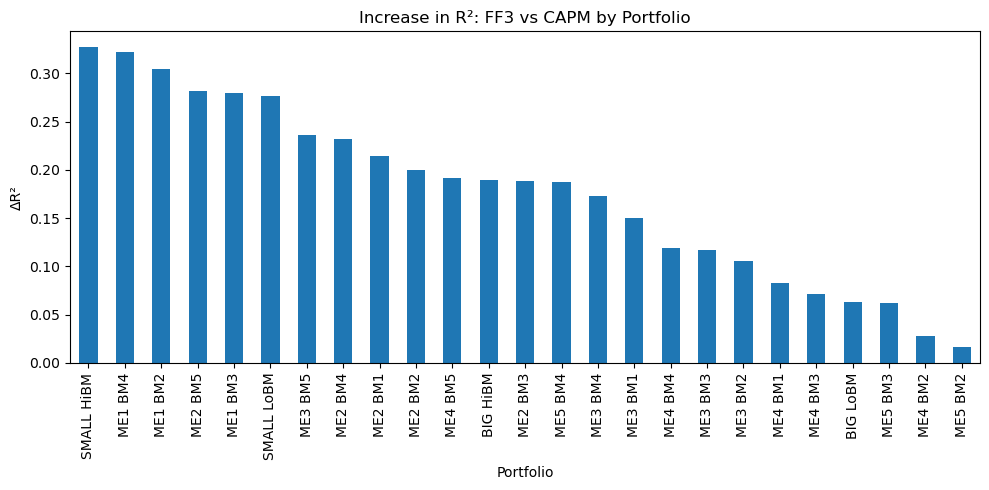

In [14]:
import matplotlib.pyplot as plt

# Plot Delta R² for all portfolios
plt.figure(figsize=(10, 5))
compare["Delta_R2"].plot(kind="bar")
plt.title("Increase in R²: FF3 vs CAPM by Portfolio")
plt.ylabel("ΔR²")
plt.xlabel("Portfolio")
plt.tight_layout()
plt.show()


### Figure 2: Model Fit Comparison (CAPM vs FF3)

This scatter plot compares R² values from the CAPM and FF3 models. Points above the 45-degree line indicate portfolios for which FF3 provides a better fit.


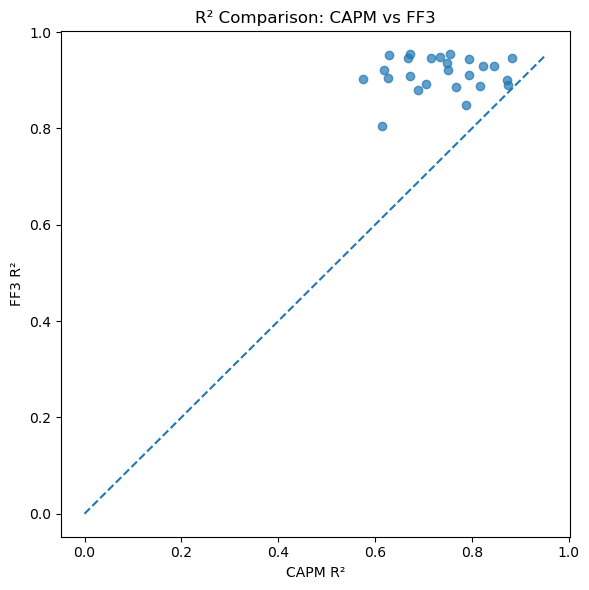

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(compare["R2_CAPM"], compare["R2_FF3"], alpha=0.7)

# 45-degree line
max_r2 = max(compare["R2_CAPM"].max(), compare["R2_FF3"].max())
plt.plot([0, max_r2], [0, max_r2], linestyle="--")

plt.xlabel("CAPM R²")
plt.ylabel("FF3 R²")
plt.title("R² Comparison: CAPM vs FF3")
plt.tight_layout()
plt.show()


### Figure 3: Pricing Errors (Significant Alphas)

This figure compares the number of portfolios with statistically significant alphas under the CAPM and FF3 models (p < 0.05).


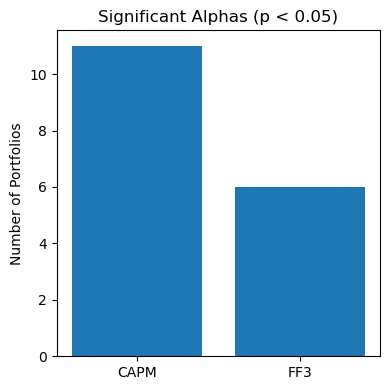

In [16]:
sig_counts = {
    "CAPM": (compare["Alpha_p_CAPM"] < 0.05).sum(),
    "FF3": (compare["Alpha_p_FF3"] < 0.05).sum()
}

plt.figure(figsize=(4, 4))
plt.bar(sig_counts.keys(), sig_counts.values())
plt.ylabel("Number of Portfolios")
plt.title("Significant Alphas (p < 0.05)")
plt.tight_layout()
plt.show()


In [11]:
print("Average R² CAPM:", compare["R2_CAPM"].mean())
print("Average R² FF3 :", compare["R2_FF3"].mean())
print("Average ΔR²    :", compare["Delta_R2"].mean())

sig_alpha_capm = (compare["Alpha_p_CAPM"] < 0.05).sum()
sig_alpha_ff3  = (compare["Alpha_p_FF3"] < 0.05).sum()

print("\nSignificant alpha (p<0.05):")
print("CAPM:", sig_alpha_capm, "out of", len(compare))
print("FF3 :", sig_alpha_ff3, "out of", len(compare))


Average R² CAPM: 0.7371304377312667
Average R² FF3 : 0.9137873625510453
Average ΔR²    : 0.17665692481977874

Significant alpha (p<0.05):
CAPM: 11 out of 25
FF3 : 6 out of 25


The results show a substantial improvement in explanatory power when moving from
CAPM to the Fama–French Three-Factor Model. On average, FF3 increases R² by
approximately 18 percentage points across portfolios.

Additionally, the number of statistically significant alphas declines under FF3,
indicating that the inclusion of size and value factors reduces systematic pricing
errors left unexplained by CAPM.


In [12]:
ff3_betas = ff3[["beta_Mkt-RF", "beta_SMB", "beta_HML"]].copy()
ff3_betas = ff3_betas.sort_index()

ff3_betas.style.format("{:.2f}")


,beta_Mkt-RF,beta_SMB,beta_HML
portfolio,,,
BIG HiBM,1.12,-0.08,0.84
BIG LoBM,0.99,-0.23,-0.32
ME1 BM2,0.95,1.31,-0.20
ME1 BM3,0.93,1.09,0.11
ME1 BM4,0.88,1.08,0.30
ME2 BM1,1.11,1.06,-0.51
ME2 BM2,1.00,0.94,-0.05
ME2 BM3,0.97,0.77,0.25
ME2 BM4,0.95,0.74,0.45


In [13]:
compare[["Delta_R2", "R2_CAPM", "R2_FF3"]].head(10).style.format("{:.3f}")


,Delta_R2,R2_CAPM,R2_FF3
portfolio,,,
SMALL HiBM,0.327,0.576,0.903
ME1 BM4,0.322,0.629,0.951
ME1 BM2,0.304,0.618,0.922
ME2 BM5,0.282,0.672,0.954
ME1 BM3,0.279,0.667,0.946
SMALL LoBM,0.277,0.627,0.904
ME3 BM5,0.236,0.672,0.909
ME2 BM4,0.232,0.715,0.947
ME2 BM1,0.215,0.734,0.949


## 4. Conclusion

This project demonstrates that the Fama–French Three-Factor Model provides a
significantly better explanation of cross-sectional equity returns than the
Capital Asset Pricing Model.

The empirical results are consistent with asset pricing theory, showing that size
and value factors capture systematic risk dimensions not explained by market
exposure alone. These findings highlight the importance of multifactor models in
both academic research and practical portfolio analysis.
